In [943]:
import pandas as pd
import yfinance as yf
import numpy as np
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [1012]:
class stock:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.startDate = start
        self.endDate = end
    
        self.data = yf.download(self.ticker, 
                      start = self.startDate, 
                      end = self.endDate,
                      progress=False)
        
        self.dailyReturns = self.data['Adj Close']/self.data['Adj Close'].shift(1)-1
        self.dailyReturns.columns = self.ticker
        self.dailyReturns.name = self.ticker
    
    def print_data(self):
        print(self.data)


In [1091]:
class portfolio:
    def __init__(self, tickers, start, end):
        self.tickers = tickers
        self.weight = [] 
        self.data = {}
        self.startDate = start
        self.endDate = end
        self.dailyReturns = None
        self.portfolioValue = pd.DataFrame()
        self.adjPrice = None
        
        # pull our stock data and initialize portfolioValue
        for ticker in self.tickers:  
            self.data[ticker] = stock(ticker, self.startDate, self.endDate)
            self.adjPrice = pd.concat([self.adjPrice, self.data[ticker].data['Adj Close']], axis=1)
            if self.portfolioValue.empty:
                self.portfoliovalue = pd.DataFrame(np.zeros(len(self.data[ticker].data.index)),
                                                   index = self.data[ticker].data.index, 
                                                   columns = ['Value']) 
        self.adjPrice.columns = self.tickers
        
        self.trainSize = 2/3
        self.trainSet = None
        self.testSet = None
        
        for ticker in self.tickers:
            self.dailyReturns = pd.concat([self.dailyReturns, self.data[ticker].dailyReturns], axis=1)
        self.dailyReturns = self.dailyReturns.dropna()
        
        self.covariance = np.cov([self.dailyReturns[ticker] for ticker in self.tickers])
        
        numTradingDays = len(self.data[self.tickers[0]].data)
        split = int(numTradingDays * self.trainSize)
        self.trainSet = self.dailyReturns.iloc[:split]
        self.testSet = self.dailyReturns.iloc[split:numTradingDays]
        self.tau = []
        self.e = np.array([[1] for ticker in self.tickers])
        
    def set_weight(self, weight):
        self.weight = weight
        
    def print_data(self):
        for ticker in self.tickers:
            self.data[ticker].print_data()
    
    def get_estimate_returns(self, train = True):  # mu: daily mean return
        if train:
            return np.array(self.trainSet.mean(axis=0))[np.newaxis].T
        else:
            return np.array(self.testSet.mean(axis=0))[np.newaxis].T
        
    def get_estimate_covariance(self, train = True):  # Sigma: daily covariance matrix
        if train: 
            return np.cov([self.trainSet[ticker] for ticker in self.tickers])
        else:
            return np.cov([self.testSet[ticker] for ticker in self.tickers])
        
    def get_weight(self):
        return self.weight
    
    def set_tau(self, tau):
        self.tau = tau
    
    def get_weight_mz(self):  # get w_m and w_z
        mu = self.get_estimate_returns()
        sigma = self.get_estimate_covariance()
        sigmaInverse = np.linalg.inv(sigma)
        w_m = np.dot(sigmaInverse, self.e) / np.dot(np.dot(self.e.T, sigmaInverse), self.e)
        w_z = np.dot(sigmaInverse, mu) - (np.dot(np.dot(self.e.T, sigmaInverse), mu) / np.dot(np.dot(self.e.T, sigmaInverse), self.e)) * np.dot(sigmaInverse, self.e)
        return [w_m, w_z]
    
    def get_weight_opt(self):
        w_m, w_z = self.get_weight_mz()
        return self.tau * w_z + w_m
        
    def get_mu_opt(self, train = True):
        if train:
            return np.dot(self.get_estimate_returns().T, self.get_weight_opt())
        else:
            return np.dot(self.get_estimate_returns(False).T, self.get_weight_opt())
    
    def get_sigma_opt(self, train = True):
        if train:
            sigma = self.get_estimate_covariance()
        else:
            sigma = self.get_estimate_covariance(train = False)
        w_opt = self.get_weight_opt()
        sigma_opt = []
        for w in w_opt.T:
            sigma_opt.append(np.sqrt(np.dot(np.dot(w, sigma), w.T)))
        return sigma_opt
    
    def get_my_mu(self, train = True): # get the mean return given the weight
        if train:
            return np.dot(self.get_estimate_returns().T, self.weight)
        else:
            return np.dot(self.get_estimate_returns(False).T, self.weight)
    
    def get_my_sigma(self, train = True):
        if train:
            sigma = self.get_estimate_covariance()
        else:
            sigma = self.get_estimate_covariance(False)
        return np.dot(np.dot(self.weight, sigma), self.weight)
    
    def get_actual_return(self, start, end):
        actual_return = []
        for ticker in self.tickers:
            start_price = self.data[ticker].data.loc[self.data[ticker].data.index == start].values[0][4]
            end_price = self.data[ticker].data.loc[self.data[ticker].data.index == end].values[0][4]
            actual_return.append((end_price-start_price)/start_price)
        return actual_return


In [1092]:
# Construct a portfolio
Julia = ['TSLA', 'CMG', 'AAPL', 'DIS', 'LULU', 'NEE', 'NFLX', 'NIO', 'ORCL', 'PRPL']
Barrons = ['GOOGL', 'AAPL', 'BRK-B', 'KO', 'ETN', 'GS', 'GHC', 'DIS', 'MRK', 'NEM']
tau = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
mp = portfolio(Barrons, '2019-02-19', '2021-02-19')
mp.set_tau(tau)
w_opt = mp.get_weight_opt()
mu_opt = mp.get_mu_opt()[0]
sigma_opt = mp.get_sigma_opt()
sp500 = portfolio(['^GSPC'], '2019-02-19', '2021-02-19')
mean_return_sp500 = sp500.get_estimate_returns()
std_sp500 = np.sqrt(sp500.get_estimate_covariance())

In [1093]:
mp.set_weight([1/10 for ticker in Julia])
mean_return_N1_strategy = mp.get_my_mu()
std_N1_strategy = np.sqrt(mp.get_my_sigma())

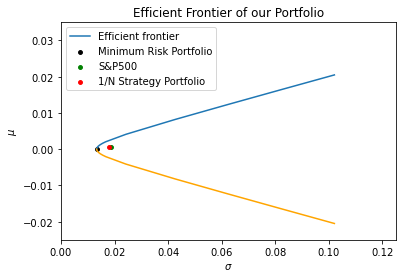

In [1094]:
effFrontier = plt.plot(sigma_opt, mu_opt, label = "Efficient frontier")
plt.plot(sigma_opt, -mu_opt, color = "orange")
plt.ylim(-0.025, 0.035)
plt.xlim(0, 0.125)
plt.scatter(sigma_opt[0], mu_opt[0], color ="black", label = "Minimum Risk Portfolio", s=15)
plt.scatter(std_sp500, mean_return_sp500, color = "green", label = "S&P500", s=15)
plt.scatter(std_N1_strategy, mean_return_N1_strategy, color = "red", label = "1/N Strategy Portfolio", s=15)
plt.title('Efficient Frontier of our Portfolio')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.legend(loc="upper left")
plt.savefig('EfficientFrontier.png')

In [1095]:
def annualize(daily_mu):   # returns the annualized
    return (daily_mu + 1)**252 - 1

annualized_mu_opt = annualize(mu_opt)
print(mu_opt)
print(annualized_mu_opt)

[7.08685594e-06 4.16895595e-04 8.26704335e-04 1.23651307e-03
 1.64632181e-03 2.05613055e-03 4.10517425e-03 8.20326164e-03
 1.23013490e-02 1.63994364e-02 2.04975238e-02]
[1.78747700e-03 1.10750371e-01 2.31512916e-01 3.65347266e-01
 5.13662127e-01 6.78017340e-01 1.80775799e+00 6.83647440e+00
 2.07807853e+01 5.92882565e+01 1.65193000e+02]


In [1096]:
# Tabulate the stocks
mean_daily_return = mp.get_estimate_returns()
mean_annualized_return = annualize(mean_daily_return)
actual_return = mp.get_actual_return('2019-02-19', '2020-02-19')

In [1097]:
# Optimal weight for each tau
df = pd.DataFrame(mp.get_weight_opt().T, columns = Barrons)
df.insert(0, column = 'tau', value = tau)

In [1192]:
# annualize riskfree rate
riskfree = pd.read_csv("DGS10.csv")
# fill in the empty values with previous values
i = 1
riskfree.at[0, 'DGS10'] = float(riskfree.at[0, 'DGS10'])
for row in riskfree.itertuples():
    try:
        riskfree.at[i, 'DGS10'] = float(riskfree.at[i, 'DGS10'])
    except:
        riskfree.at[i, 'DGS10'] = riskfree.at[i-1, 'DGS10']
    i += 1

# daily riskfree rate
riskfree['DGS10'] = riskfree['DGS10'].add(1)**(1/365)-1

# delete the unwanted riskfree rate(match with the daily returns)
import math
i = 0
for row in riskfree.itertuples():
    if row.DATE not in mp.dailyReturns.index:
        riskfree = riskfree.drop([i])
    i += 1
riskfree.reset_index(inplace=True)
print(mp.get_mu_opt())
print(mp.get_mu_opt(False))

[[7.08685594e-06 4.16895595e-04 8.26704335e-04 1.23651307e-03
  1.64632181e-03 2.05613055e-03 4.10517425e-03 8.20326164e-03
  1.23013490e-02 1.63994364e-02 2.04975238e-02]]
[[0.00099654 0.00104198 0.00108742 0.00113286 0.0011783  0.00122373
  0.00145093 0.00190531 0.0023597  0.00281408 0.00326847]]


$$r_p = r_f + \beta(r_m - r_f)$$
$$r_p-r_f = \beta(r_m - r_f) $$

In [1233]:
# We want to estimate beta by linear regression(with no intercept)
market_premium = np.array(sp500.dailyReturns['^GSPC']) - np.array(riskfree['DGS10'])

In [1165]:
# Optimal portfolio daily return
portfolio_daily_return = pd.DataFrame()
i = 0
for w in w_opt.T:
    portfolio_daily_return = pd.concat([portfolio_daily_return, pd.DataFrame(np.dot(mp.trainSet, np.array([w]).T), columns=["tau=" + str(tau[i])])], axis = 1)
    i += 1
# mean daily returns
portfolio_daily_return.mean(axis = 0)

tau=0       0.000007
tau=0.01    0.000417
tau=0.02    0.000827
tau=0.03    0.001237
tau=0.04    0.001646
tau=0.05    0.002056
tau=0.1     0.004105
tau=0.2     0.008203
tau=0.3     0.012301
tau=0.4     0.016399
tau=0.5     0.020498
dtype: float64

In [1234]:
beta_opt = []
graph = []
for column in portfolio_daily_return:
    portfolio_premium = np.array(portfolio_daily_return[column] - riskfree['DGS10'][0:336])
    mod = LinearRegression(fit_intercept = False).fit(market_premium[0:336].reshape(-1, 1), portfolio_premium.reshape(-1, 1))
    beta_opt = beta_opt + [mod.coef_.item(0)]
#     print(np.mean(portfolio_premium))
#     plt.figure()
#     graph.append(plt.scatter(market_premium[0:336], portfolio_premium))
#     pred = mod.predict(market_premium[0:336].reshape(-1, 1))
#     plt.plot(market_premium[0:336], pred, color = "red")

[-0.027056042518623258,
 0.11586941647330695,
 0.27795795263015677,
 0.4615023288241136,
 0.669030394979296,
 0.9033239535882025,
 2.59396107452735,
 10.544126111922486,
 31.32002138614684,
 77.90826578664739,
 166.74816777370933]

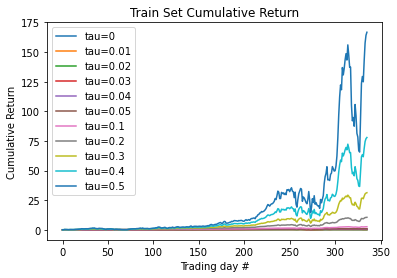

In [1312]:
# get the cumulative return of each portfolio
cumulative_return = []
for column in portfolio_daily_return:
    cr = np.prod(np.array(portfolio_daily_return[column])+1)-1
    cumulative_return = cumulative_return + [cr]
sp500_cumulative = np.prod(np.array(sp500.dailyReturns['^GSPC'][0:336]) + 1)-1
N1_cumulateive = np.prod(np.array(mp.trainSet.mean(axis = 1)) + 1)-1
((portfolio_daily_return+1).cumprod()-1).plot()
plt.xlabel("Trading day #")
plt.ylabel("Cumulative Return")
plt.title("Train Set Cumulative Return")
plt.savefig("Train Set Cumulative Return")
cumulative_return

In [1240]:
# get S&P500 and 1/N beta
N1_daily_return = np.array(mp.trainSet.mean(axis = 1))
N1_premium = np.array(N1_daily_return - riskfree['DGS10'][0:336])
portfolio_premium = np.array(portfolio_daily_return[column] - riskfree['DGS10'][0:336])
N1_mod = mod = LinearRegression(fit_intercept = False).fit(market_premium[0:336].reshape(-1, 1), N1_premium.reshape(-1, 1))
N1_beta = N1_mod.coef_.item(0)

$$Sharpe Ratio = \frac{E[R_a-R_b]}{\sigma_a}$$

In [1230]:
# get the excess return standard deviation
excess_return_opt = np.array(np.dot(mp.trainSet, mp.get_weight_opt()) - np.mean(riskfree['DGS10'][0:336])).T
std_excess_opt = []
for row in excess_return_opt:
    std_excess_opt = std_excess_opt + [np.std(row)]

excess_return_N1 = np.mean(mp.trainSet, axis = 1) - np.mean(riskfree['DGS10'][0:336])
std_excess_N1 = np.std(excess_return_N1)

excess_return_sp500 = sp500.trainSet['^GSPC'] - np.mean(riskfree['DGS10'][0:336])
std_excess_sp500 = np.std(excess_return_sp500)

# get the Sharpe Ratio
sharpe_ratio_opt = np.divide(np.array(mp.get_mu_opt() - np.mean(riskfree['DGS10'][0:336])), std_excess_N1)
sharpe_ratio_N1 = (mp.get_my_mu() - np.mean(riskfree['DGS10'][0:336]))/std_excess_N1
sharpe_ratio_sp500 = (sp500.get_estimate_returns() - np.mean(riskfree['DGS10'][0:336]))/std_excess_sp500

$$Treynor Ratio = \frac{r_p - r_f}{\beta_p}$$

In [1231]:
# get the Treynor Ratio
treynor_ratio_opt = np.divide(np.array(mp.get_mu_opt() - np.mean(riskfree['DGS10'][0:336])), beta_opt)
treynor_ratio_N1 = (mp.get_my_mu() - np.mean(riskfree['DGS10'][0:336]))/N1_beta
treynor_ratio_sp500 = (sp500.get_estimate_returns() - np.mean(riskfree['DGS10'][0:336]))/1

$$Jensen's Alpha = R_p - [R_f + \beta(R_M - R_f)]$$

In [1232]:
# get the Jensen's Alpha
alpha_opt = mp.get_mu_opt() - np.array(sp500.get_estimate_returns() - np.mean(riskfree['DGS10'][0:336])) * beta_opt + np.mean(riskfree['DGS10'][0:336])
alpha_N1 = mp.get_my_mu() - np.array(sp500.get_estimate_returns() - np.mean(riskfree['DGS10'][0:336])) * N1_beta + np.mean(riskfree['DGS10'][0:336])
alpha_sp500 = 0

## Out-of-Sample Evaluation

In [1172]:
# get mean daily return from testset
mean_daily_return_opt_test = mp.get_mu_opt(False)
mean_daily_return_N1_test = mp.get_my_mu(False)
mean_daily_return_sp500_test = sp500.get_estimate_returns(False)

In [1173]:
# get daily standard deviation from testset
std_opt_test = mp.get_sigma_opt(train = False)
std_N1_test = np.sqrt(mp.get_my_sigma(train = False))
std_sp500_test = np.sqrt(sp500.get_estimate_covariance(train = False))
std_sp500_test

0.01050748386128194

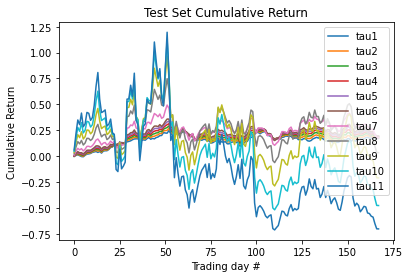

In [1315]:
# get cumulative return from test set
cumulative_opt_test = np.prod(np.dot(mp.testSet, mp.get_weight_opt()) + 1, axis = 0) - 1
cumulative_N1_test = np.prod(np.dot(mp.testSet, mp.weight) + 1, axis = 0) - 1
cumulative_sp500_test = np.prod(sp500.testSet + 1, axis = 0) - 1
daily_return = np.dot(mp.testSet, mp.get_weight_opt())
cumulative_opt_test = pd.DataFrame(daily_return, columns = ['tau' + str(i) for i in range(1, 12)])
((cumulative_opt_test+1).cumprod()-1).plot()
plt.xlabel("Trading day #")
plt.ylabel("Cumulative Return")
plt.title("Test Set Cumulative Return")
plt.savefig("Test Set Cumulative Return")

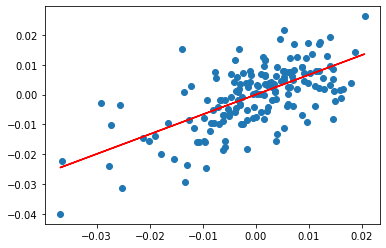

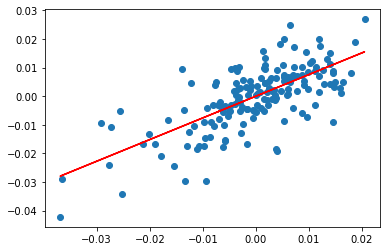

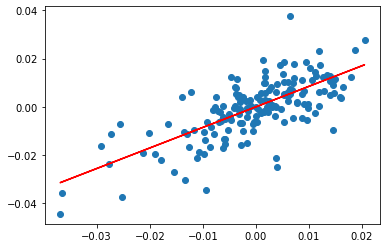

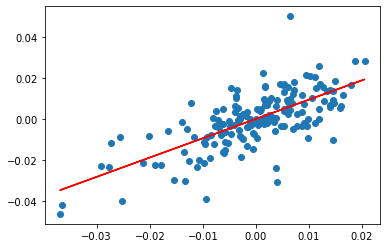

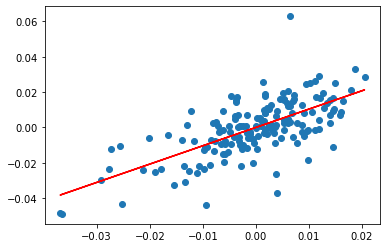

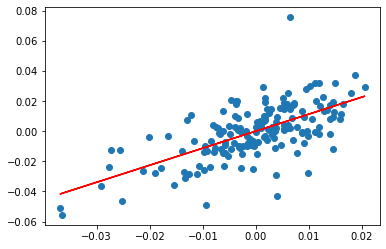

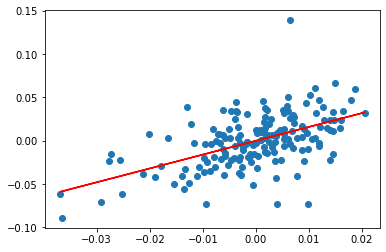

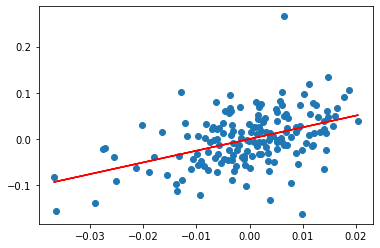

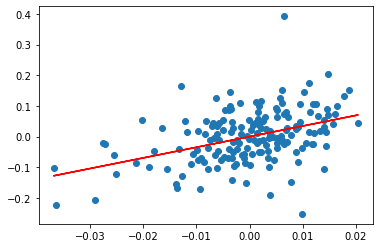

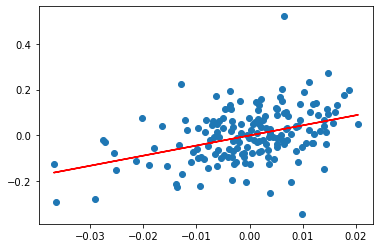

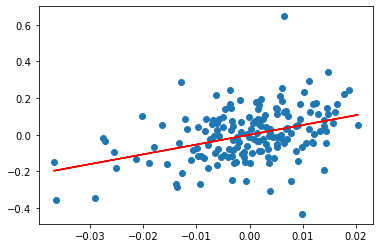

In [1330]:
# get the beta
portfolio_daily_return_test = np.dot(mp.testSet, mp.get_weight_opt()).T
graph = []
i = 0
beta_opt_test = []
for column in portfolio_daily_return_test:
    portfolio_premium = np.array(column - riskfree['DGS10'][336:504])
    mod = LinearRegression(fit_intercept = False).fit(market_premium[336:504].reshape(-1, 1), portfolio_premium.reshape(-1, 1))
    beta_opt_test = beta_opt_test + [mod.coef_.item(0)]
    plt.figure()
    graph.append(plt.scatter(market_premium[336:504], portfolio_premium))
    pred = mod.predict(market_premium[336:504].reshape(-1, 1))
    plt.plot(market_premium[336:504], pred, color = "red")


In [1239]:
# get 1/N strategy beta
N1_daily_return_test = np.array(mp.testSet.mean(axis = 1))
N1_premium_test = np.array(N1_daily_return_test - riskfree['DGS10'][336:504])
portfolio_premium = np.array(portfolio_daily_return[column] - riskfree['DGS10'][336:504])
N1_mod_test = LinearRegression(fit_intercept = False).fit(market_premium[336:504].reshape(-1, 1), N1_premium_test.reshape(-1, 1))
N1_beta_test = N1_mod_test.coef_.item(0)

$$Sharpe Ratio = \frac{E[R_a-R_b]}{\sigma_a}$$

In [1244]:
# get the excess return standard deviation
excess_return_opt_test = np.array(np.dot(mp.testSet, mp.get_weight_opt()) - np.mean(riskfree['DGS10'][336:504])).T
std_excess_opt_test = []
for row in excess_return_opt_test:
    std_excess_opt_test = std_excess_opt_test + [np.std(row)]

excess_return_N1_test = np.mean(mp.testSet, axis = 1) - np.mean(riskfree['DGS10'][336:504])
std_excess_N1_test = np.std(excess_return_N1_test)

excess_return_sp500_test = sp500.trainSet['^GSPC'] - np.mean(riskfree['DGS10'][336:504])
std_excess_sp500_test = np.std(excess_return_sp500_test)

# get the Sharpe Ratio
sharpe_ratio_opt = np.divide(np.array(mp.get_mu_opt(False) - np.mean(riskfree['DGS10'][336:504])), std_excess_N1_test)
sharpe_ratio_N1 = (mp.get_my_mu(False) - np.mean(riskfree['DGS10'][336:504]))/std_excess_N1_test
sharpe_ratio_sp500 = (sp500.get_estimate_returns(False) - np.mean(riskfree['DGS10'][336:504]))/std_excess_sp500_test
sharpe_ratio_sp500

array([[-0.0118874]])

$$Treynor Ratio = \frac{r_p - r_f}{\beta_p}$$

In [1324]:
# get the Treynor Ratio
treynor_ratio_opt_test = np.divide(mp.get_mu_opt(False) - np.mean(riskfree['DGS10'][336:504]), beta_opt_test)
treynor_ratio_N1_test = (mp.get_my_mu(False) - np.mean(riskfree['DGS10'][336:504]))/N1_beta_test
treynor_ratio_sp500_test = (sp500.get_estimate_returns(False) - np.mean(riskfree['DGS10'][336:504]))/1

In [1265]:
# get the Jensen's Alpha
alpha_opt_test = mp.get_mu_opt(False) - np.array(sp500.get_estimate_returns(False) - np.mean(riskfree['DGS10'][336:504])) * beta_opt_test + np.mean(riskfree['DGS10'][336:504])
alpha_N1 = mp.get_my_mu(False) - np.array(sp500.get_estimate_returns(False) - np.mean(riskfree['DGS10'][336:504])) * N1_beta_test + np.mean(riskfree['DGS10'][336:504])
alpha_sp500 = 0